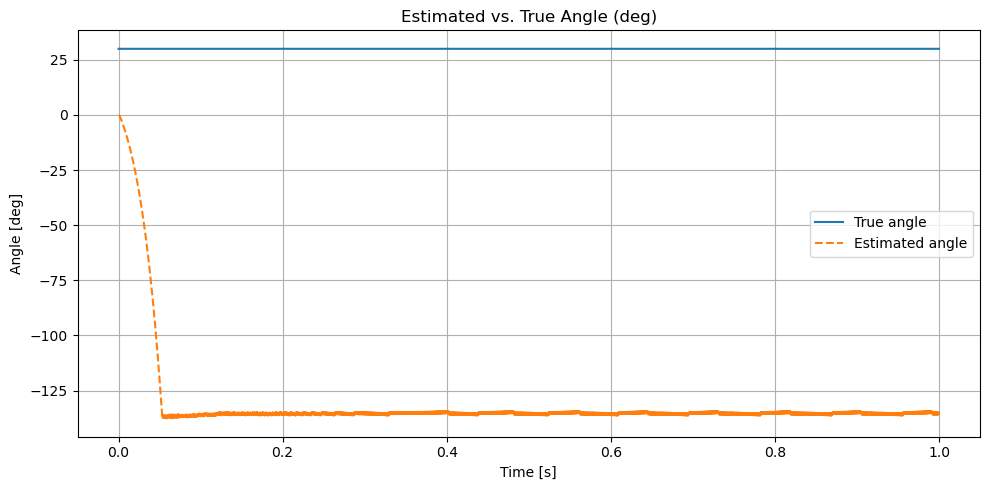

In [10]:
"""
センサレスベクトル制御 ― 主要モジュール実装例
"""

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


# ───────────────────────────────────────────────
# 0)  ユーティリティ
# ───────────────────────────────────────────────
def wrap_angle(theta: float) -> float:
    """角度を −π〜π に正規化"""
    return (theta + np.pi) % (2 * np.pi) - np.pi


# ───────────────────────────────────────────────
# 1)  HFV  ― 高周波回転電圧指令ジェネレータ
# ───────────────────────────────────────────────
class HFVGenerator:
    """
    高周波回転電圧 v*1h = Vh [cosφh, sinφh]^T を生成
    """

    def __init__(self, Vh: float, omega_h: float, Ts: float) -> None:
        self.Vh = Vh          # [V]
        self.omega_h = omega_h  # [rad/s]
        self.Ts = Ts
        self.phi_h = 0.0      # 位相レジスタ

    def update(self) -> np.ndarray:
        """1 サンプル分の高周波電圧ベクトルを返す"""
        self.phi_h = wrap_angle(self.phi_h - self.omega_h * self.Ts)#reverse
        # self.phi_h = wrap_angle(self.phi_h + self.omega_h * self.Ts)
        v_alpha = self.Vh * np.cos(self.phi_h)
        v_beta  = self.Vh * np.sin(self.phi_h)
        return np.array([v_alpha, v_beta], dtype=float)


# ───────────────────────────────────────────────
# 2)  D-module フィルタ  ─ 同相/鏡相電流抽出器
# ───────────────────────────────────────────────
class DModuleFilter:
    def __init__(self, omega_h: float, Ts: float, zeta: float = 0.1) -> None:
        fs = 1 / Ts
        f0 = omega_h / (2 * np.pi)
        bw = f0 * zeta            # 帯域幅の簡易指定
        self.b_i, self.a_i = signal.butter(
            N=2,
            Wn=[f0 - bw, f0 + bw],
            btype="bandpass",
            fs=fs,
        )

        zi0 = signal.lfilter_zi(self.b_i, self.a_i)
        self.zi_alpha = zi0.copy()
        self.zi_beta  = zi0.copy()

    def update(self, i_alpha_beta: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        iα, iβ = i_alpha_beta

        yα, self.zi_alpha = signal.lfilter(
            self.b_i, self.a_i, [iα], zi=self.zi_alpha
        )
        yβ, self.zi_beta = signal.lfilter(
            self.b_i, self.a_i, [iβ], zi=self.zi_beta
        )

        i_hi = np.array([yα[0], yβ[0]])
        i_hm = -i_hi                       # 近似：鏡相 = −同相
        return i_hi, i_hm


# ───────────────────────────────────────────────
# 2')  DModuleFilter2 ― “正統” D因子フィルタ実装
#        ・複素周波数シフト＋ローパスで同相／鏡相を抽出
#        ・論文の F(D)=F(s+jωh), F(s−jωh) に相当
# ───────────────────────────────────────────────
class DModuleFilter2:
    """
    D因子理論に忠実な 2ch フィルタ
    ---------------------------------
    1. αβ 電流を複素数 I = iα + j iβ に変換
    2. 正の回転 e^{−jωh t} を掛けて直流化 → 低域通過  → 同相電流
    3. 負の回転 e^{+jωh t} を掛けて直流化 → 低域通過  → 鏡相電流
       （“鏡”なので周波数符号が逆転）
    4. ベースバンド出力を再び実数ベクトル [α, β] へ戻す
    """

    def __init__(
        self,
        omega_h: float,
        Ts: float,
        lp_order: int = 2,
        lp_cutoff_hz: float | None = None,
    ) -> None:
        """
        Parameters
        ----------
        omega_h : float
            高周波注入角速度 [rad/s]
        Ts : float
            制御周期 [s]
        lp_order : int
            ローパスフィルタ次数（Butterworth）
        lp_cutoff_hz : float | None
            カットオフ周波数 [Hz]  
            未指定なら 0.25·ωh を自動設定（十分に ωh≫fc）
        """
        self.Ts = Ts
        self.omega_h = omega_h
        self.phi = 0.0  # 内部位相レジスタ

        fs = 1.0 / Ts
        if lp_cutoff_hz is None:
            lp_cutoff_hz = (omega_h / (2 * np.pi)) * 0.25  # ωh の 1/4

        # Butterworth デジタル LPF 設計
        self.b_lp, self.a_lp = signal.butter(
            N=lp_order, Wn=lp_cutoff_hz, btype="low", fs=fs
        )

        # lfilter の内部状態（複素数用）
        zi_template = signal.lfilter_zi(self.b_lp, self.a_lp).astype(complex)
        self.zi_i = zi_template.copy()  # in-phase 用
        self.zi_m = zi_template.copy()  # mirror-phase 用

    # ----------------------------------------------------------
    # メイン処理
    # ----------------------------------------------------------
    def update(self, i_alpha_beta: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Parameters
        ----------
        i_alpha_beta : np.ndarray shape(2,)
            ステータ αβ 電流 [A]

        Returns
        -------
        i_hi : np.ndarray shape(2,)  # 同相電流
        i_hm : np.ndarray shape(2,)  # 鏡相電流
        """
        # ① 実 → 複素（α+ jβ）
        i_complex = i_alpha_beta[0] + 1j * i_alpha_beta[1]

        # 内部位相を進める
        self.phi = wrap_angle(self.phi + self.omega_h * self.Ts)
        ejp   = np.exp(-1j * self.phi)  # e^{-jωh t}  … 同相
        ejm   = np.exp(+1j * self.phi)  # e^{+jωh t}  … 鏡相

        # ② 周波数シフト
        x_i = i_complex * ejp   # 正シフト で +ωh を 0 へ
        x_m = i_complex * ejm   # 負シフト で −ωh を 0 へ

        # ③ LPF 通過
        y_i, self.zi_i = signal.lfilter(self.b_lp, self.a_lp, [x_i], zi=self.zi_i)
        y_m, self.zi_m = signal.lfilter(self.b_lp, self.a_lp, [x_m], zi=self.zi_m)

        # ④ 複素 → 実ベクトルに戻す（α=Re, β=Im）
        i_hi = np.array([y_i.real[0], y_i.imag[0]])
        i_hm = np.array([y_m.real[0], y_m.imag[0]])

        return i_hi, i_hm


# ───────────────────────────────────────────────
# 3)  Phase Estimator（D-module + PLL）
# ───────────────────────────────────────────────
class PhaseEstimator:
    """
    ・DModuleFilter で同相/鏡相電流を抽出
    ・PLL（比例＋積分）で電気角と電気角速度を推定
    """

    def __init__(
        self,
        omega_h: float,
        Ts: float,
        Kp: float = 20.0,
        Ki: float = 400.0,
        zeta: float = 0.1,
    ) -> None:
        self.Ts = Ts
        # self.filter = DModuleFilter(omega_h, Ts, zeta)
        self.filter = DModuleFilter2(omega_h, Ts, lp_order=2)
        self.Kp = Kp
        self.Ki = Ki
        self.theta_e = 0.0  # 電気角推定値
        self.omega_e = 0.0  # 電気角速度推定値
        self.err_int = 0.0  # 誤差積分

    def _phase_error(self, i_hi: np.ndarray) -> float:
        """
        PLL 位相誤差計算
        dq 座標で d 成分（推定座標系）を負符号で返す
        """
        # αβ → dq 変換（推定角で Park 変換）
        ca, sa = np.cos(self.theta_e), np.sin(self.theta_e)
        i_d =  ca * i_hi[0] + sa * i_hi[1]
        # PLL 用誤差は −i_d とする（文献式 18 相当）
        return -i_d

    def update(self, i_alpha_beta: np.ndarray) -> tuple[
        float,  # θ̂e
        float,  # sinθ̂e
        float,  # cosθ̂e
        float,  # ω̂e
        float,  # i_d  ←★追加
        float,  # i_q  ←★追加
    ]:
        # ── 1. HF 同相・鏡相抽出 ─────────────────────────
        i_hi, _ = self.filter.update(i_alpha_beta)

        # ── 2. Park 変換（推定角）───────────────────────
        ca, sa = np.cos(self.theta_e), np.sin(self.theta_e)
        i_d =  ca * i_hi[0] + sa * i_hi[1]
        i_q = -sa * i_hi[0] + ca * i_hi[1]
        # ── 3. PLL 誤差（i_d ≒ 0 を狙う）────────────────
        # err = -i_d         # 文献式 (18)
        err = -i_d         # 文献式 (18)

        # ── 4. PI-PLL ──────────────────────────────────
        self.err_int += err * self.Ts
        self.omega_e = self.Kp * err + self.Ki * self.err_int
        self.theta_e = wrap_angle(self.theta_e + self.omega_e * self.Ts)

        return self.theta_e, np.sin(self.theta_e), np.cos(self.theta_e), \
               self.omega_e, i_d, i_q

    # ------------------------- 新しい誤差計算 -------------------------
    @staticmethod
    def _c2p_s2p(i_hi: np.ndarray, i_hm: np.ndarray) -> tuple[float, float]:
        """C2p = i_hi·i_hm,  S2p = (J i_hi)·i_hm"""
        C2p = float(np.dot(i_hi, i_hm))                 # i_x*i'_x + i_y*i'_y
        S2p = float(i_hi[0]*i_hm[1] - i_hi[1]*i_hm[0])  # i_x*i'_y − i_y*i'_x
        return C2p, S2p

    # ------------------------- 位相誤差(2倍角) -------------------------
    def _phase_error_2p(self, i_hi: np.ndarray, i_hm: np.ndarray) -> float:
        C2p, S2p = self._c2p_s2p(i_hi, i_hm)
        theta_gamma = 0.5 * np.arctan2(S2p, C2p)        # 文献(18)
        # return wrap_angle(theta_gamma - self.theta_e)   # PLL 用誤差
        return wrap_angle(self.theta_e - theta_gamma)   # PLL 用誤差

    # ------------------------- update -------------------------------
    def update2(self, i_alpha_beta: np.ndarray):
        # 1) HF 分離
        i_hi, i_hm = self.filter.update(i_alpha_beta)

        # 2) 位相誤差（2倍角法）
        err = self._phase_error_2p(i_hi, i_hm)

        # 3) PI-PLL
        self.err_int += err * self.Ts
        self.omega_e = self.Kp * err + self.Ki * self.err_int
        self.theta_e = wrap_angle(self.theta_e + self.omega_e * self.Ts)

        # 4) ついでに i_d, i_q も返すなら……
        ca, sa = np.cos(self.theta_e), np.sin(self.theta_e)
        i_d =  ca * i_hi[0] + sa * i_hi[1]
        i_q = -sa * i_hi[0] + ca * i_hi[1]

        return self.theta_e, sa, ca, self.omega_e, i_d, i_q
# ───────────────────────────────────────────────
# 4)  Speed Estimator（極対数で割るだけ）
# ───────────────────────────────────────────────
class SpeedEstimator:
    def __init__(self, pole_pairs: int) -> None:
        self.Np = pole_pairs

    def update(self, omega_e: float) -> float:
        """機械角速度 [rad/s] を返す"""
        return omega_e / self.Np


# ───────────────────────────────────────────────
# 5)  Fbs ― バンドストップ（ノッチ）フィルタ
# ───────────────────────────────────────────────
class BandStopFilter:
    """
    IIR ノッチフィルタで高周波成分を除去
    Q 値（鋭さ）が高いほど帯域が狭い
    """

    def __init__(self, omega_h: float, Ts: float, Q: float = 15.0) -> None:
        fs = 1 / Ts
        f0 = omega_h / (2 * np.pi)  # [Hz]
        b, a = signal.iirnotch(w0=f0, Q=Q, fs=fs)
        self.b, self.a = b, a
        self.zi = [signal.lfilter_zi(b, a).copy() for _ in range(2)]  # α,β 用

    def update(self, dq: np.ndarray) -> np.ndarray:
        """dq = [d, q]"""
        d, self.zi[0] = signal.lfilter(self.b, self.a, [dq[0]], zi=self.zi[0])
        q, self.zi[1] = signal.lfilter(self.b, self.a, [dq[1]], zi=self.zi[1])
        return np.array([d[0], q[0]])


# ───────────────────────────────────────────────
# 6)  サンプルメインループ（テスト用途）
# ───────────────────────────────────────────────
if __name__ == "__main__":
    # ==== パラメータ ====
    Ts = 1/(12000)          # 10 kHz 制御周期
    omega_h = 2 * np.pi * 1000.0  # 高周波 400 Hz
    Vh = 20.0            # 高周波電圧振幅
    pole_pairs = 4

    # ==== モジュール生成 ====
    hfv = HFVGenerator(Vh, omega_h, Ts)
    phase_est = PhaseEstimator(omega_h, Ts)
    speed_est = SpeedEstimator(pole_pairs)
    notch = BandStopFilter(omega_h, Ts)


# ==== シミュレーション準備 ====
R = 0.03        
Ld = 1e-3      
Lq = 1.5e-3      
theta_true = 30/180 * np.pi   # 真の角度を固定（例）
# theta_true = np.pi / 4  # 真の角度を固定（例）
id_prev = 0.0
iq_prev = 0.0

# ログ用リストを準備
theta_true_log = []
theta_est_log = []
time_log = []
# 電流振幅記録用リスト
i_alpha_log = []
i_beta_log = []
# 電圧振幅記録用リスト（追加）
v_alpha_log = []
v_beta_log = []

phi_h_log = []        # 注入角 φh
i_mag_log = []        # 電流振幅 |i|
id_log, iq_log = [], []

# ==== 1 秒シミュレーション ====
steps = int(1.0 / Ts)
# steps = 10
for k in range(steps):
    t = k * Ts  # 時間を記録

    # HFV生成
    v_hf = hfv.update()
    v_alpha, v_beta = v_hf[0], v_hf[1]  # 分解（明示的に記録）
    phi_h = hfv.phi_h               # ← 生成直後の注入角を取得
    
    # HF電圧を真の回転子座標系（dq軸）へ変換
    cos_t, sin_t = np.cos(theta_true), np.sin(theta_true)
    Vd = cos_t * v_hf[0] + sin_t * v_hf[1]
    Vq = -sin_t * v_hf[0] + cos_t * v_hf[1]

    # dq電流の簡易モデル（Euler法）
    id_new = id_prev + (Ts / Ld) * (Vd - R * id_prev)
    iq_new = iq_prev + (Ts / Lq) * (Vq - R * iq_prev)

    # 更新した電流値をαβ軸に戻す
    i_alpha = cos_t * id_new - sin_t * iq_new
    i_beta = sin_t * id_new + cos_t * iq_new
    i_αβ = np.array([i_alpha, i_beta])
    i_alpha_log.append(i_alpha)
    i_beta_log.append(i_beta)
    
    # 位相推定
    # theta, s, c, omega_e = phase_est.update(i_αβ)
    # 位相推定（戻り値に i_d, i_q が増えた）
    theta, s, c, omega_e, i_d_est, i_q_est = phase_est.update2(i_αβ)

    # ログ追加
    id_log.append(i_d_est)
    iq_log.append(i_q_est)
    
    # ログに記録
    theta_true_log.append(theta_true)
    theta_est_log.append(theta)
    time_log.append(t)
    v_alpha_log.append(v_alpha)  # 電圧αをログ
    v_beta_log.append(v_beta)    # 電圧βをログ
    i_mag_log.append(np.hypot(i_alpha, i_beta))   # √(iα²+iβ²)
    phi_h_log.append(phi_h)
    
    # 速度推定（省略可）
    omega_m = speed_est.update(omega_e)

    # Notch フィルタ適用（省略可）
    iq_dq = np.array([id_new, iq_new])
    iq_dq_filtered = notch.update(iq_dq)

    # 電流更新
    id_prev, iq_prev = id_new, iq_new

# ==== シミュレーション終了後に可視化 ====
import numpy as np
import matplotlib.pyplot as plt

# ❶ Rad → Deg へ変換
theta_true_deg = np.degrees(theta_true_log)
theta_est_deg  = np.degrees(theta_est_log)

# ❷ プロット
plt.figure(figsize=(10, 5))
plt.plot(time_log, theta_true_deg, label="True angle")
plt.plot(time_log, theta_est_deg,  "--", label="Estimated angle")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
plt.title("Estimated vs. True Angle (deg)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


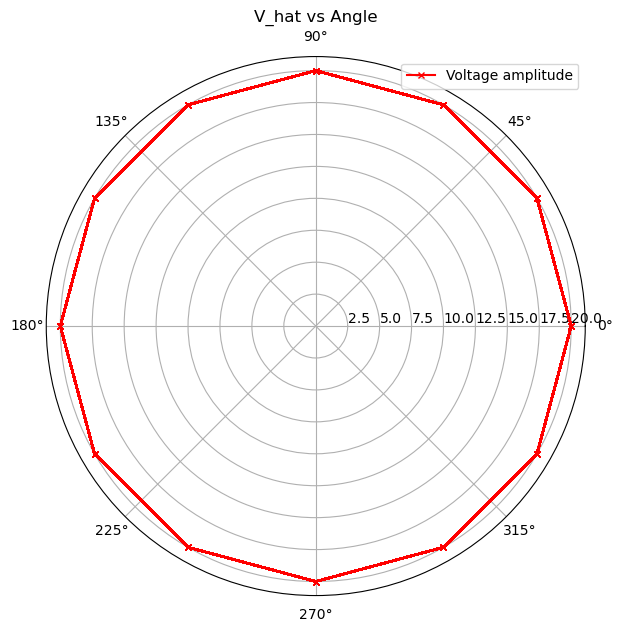

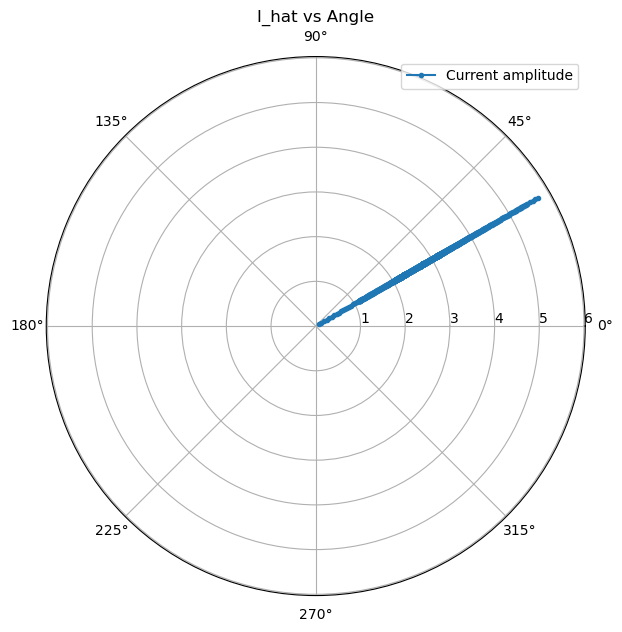

In [11]:
# 電圧振幅の計算
v_magnitude = np.sqrt(np.array(v_alpha_log)**2 + np.array(v_beta_log)**2)

# 電圧の位相を計算（αβから算出）
v_angle = np.arctan2(v_beta_log, v_alpha_log)

# 極座標プロット（電圧）
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, polar=True)

ax.plot(v_angle, v_magnitude, 'x-', markersize=4, color='r', label='Voltage amplitude')

ax.set_title('V_hat vs Angle')
ax.set_rlabel_position(0)
ax.grid(True)
ax.legend()

plt.show()

# 電流振幅の計算
i_magnitude = np.sqrt(np.array(i_alpha_log)**2 + np.array(i_beta_log)**2)

# 真の角度（固定値）を基準にして電流をプロット
angles = np.array(theta_true_log)

# 極座標プロット
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, polar=True)

ax.plot(angles, i_magnitude, 'o-', markersize=3, label='Current amplitude')

ax.set_title('I_hat vs Angle')
ax.set_rlabel_position(0)
ax.grid(True)
ax.legend()

plt.show()


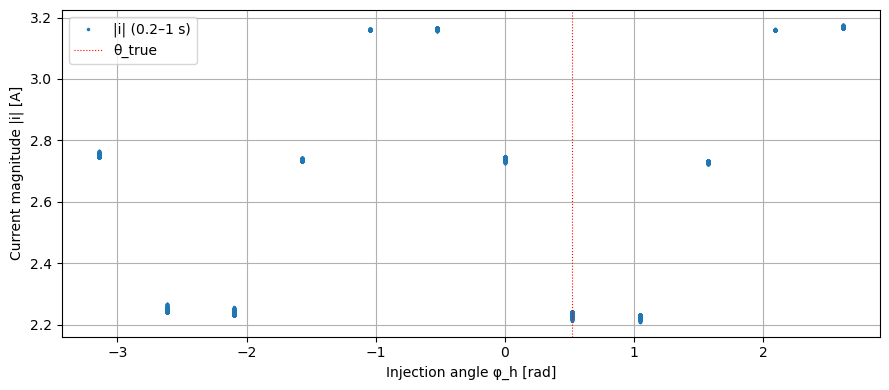

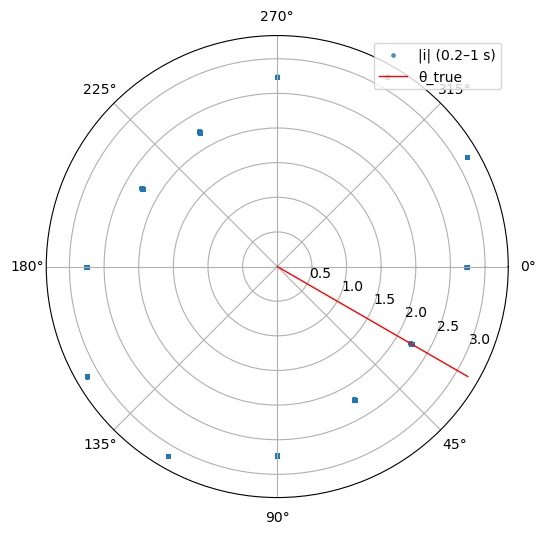

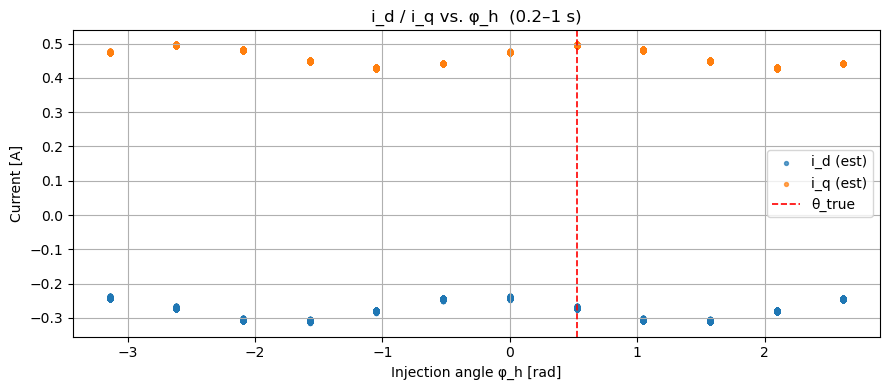

In [14]:
# ---------- 0.2–1.0 s のインデックスを抽出 ----------
t = np.asarray(time_log)
mask = (t >= 0.2) & (t <= 1.0)

# ---------- 対応する φh と |i| をスライス ----------
phi_slice = np.asarray(phi_h_log)[mask]
i_slice   = np.asarray(i_mag_log)[mask]

# ---------- プロット ----------
plt.figure(figsize=(9,4))
plt.plot(phi_slice, i_slice, '.', ms=3, label='|i| (0.2–1 s)')
plt.axvline(theta_true, c='r', ls=':', lw=0.8, label='θ_true')
plt.xlabel('Injection angle φ_h [rad]')
plt.ylabel('Current magnitude |i| [A]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# ------------- 抽出区間を指定 -------------
t_start, t_end = 0.2, 1.0                 # [s]

# ------------- マスクを作成 -------------
t_arr = np.asarray(time_log)
mask  = (t_arr >= t_start) & (t_arr <= t_end)

# ------------- スライス -------------
phi_slice  = np.asarray(phi_h_log)[mask]
i_mag_slice = np.asarray(i_mag_log)[mask]
id_slice   = np.asarray(id_log)[mask]
iq_slice   = np.asarray(iq_log)[mask]

# =========================================================
# 1) 極座標プロット（φh – |i|）
# =========================================================
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)

ax.scatter(phi_slice, i_mag_slice, s=6, alpha=0.7, label='|i| (0.2–1 s)')

# 真の角度を放射方向の線で示す
ax.plot([theta_true, theta_true], [0, i_mag_slice.max()], c='r',
        lw=1.0, label='θ_true')

ax.set_theta_zero_location('E')   # θ=0 を東（右）に
ax.set_theta_direction(-1)        # 反時計回りを正
ax.grid(True)
ax.legend(loc='upper right')
plt.show()

# =========================================================
# 2) φh vs  i_d / i_q  散布図
# =========================================================
plt.figure(figsize=(9,4))
plt.scatter(phi_slice, id_slice, s=8, label='i_d (est)', alpha=0.7)
plt.scatter(phi_slice, iq_slice, s=8, label='i_q (est)', alpha=0.7)
plt.axvline(theta_true, c='r', ls='--', lw=1.2, label='θ_true')

plt.xlabel('Injection angle φ_h [rad]')
plt.ylabel('Current [A]')
plt.title('i_d / i_q vs. φ_h  (0.2–1 s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()





| ステップ | 数式 | プログラム上の行（抜粋） | 説明 |
|---------|------|--------------------------|------|
| ① 同相電流抽出 | *i*<sub>hi</sub> ← **DModuleFilter** で αβ 電流から HF 成分を取り出し | `i_hi, i_hm = self.filter.update(i_alpha_beta)` | 高周波注入の応答成分（同相）だけを推定器へ渡す |
| ② Park 変換で d 軸電流を計算 | *i*<sub>d</sub> = cos θ̂ · i<sub>hi,α</sub> + sin θ̂ · i<sub>hi,β</sub> | `ca, sa = np.cos(self.theta_e), np.sin(self.theta_e)`<br>`i_d = ca * i_hi[0] + sa * i_hi[1]` | 推定座標系 (d-q) へ回転 |
| ③ 位相誤差 | ε = − *i*<sub>d</sub> | `return -i_d` （`_phase_error` メソッド） | d 軸電流が 0 になる方向が正しい角度なので符号反転 |
| ④ PI-PLL | ω̂<sub>e</sub> = K<sub>p</sub> ε + K<sub>i</sub> ∫ε dt<br>θ̂<sub>e</sub>(k+1) = wrap( θ̂<sub>e</sub>(k) + ω̂<sub>e</sub> T<sub>s</sub> ) | `self.err_int += err * self.Ts`  # ∫ε dt<br>`self.omega_e = self.Kp * err + self.Ki * self.err_int`<br>`self.theta_e = wrap_angle(self.theta_e + self.omega_e * self.Ts)` | PI 制御器で周波数 → 角度を更新 |


c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21454 (\N{CJK UNIFIED IDEOGRAPH-53CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26463 (\N{CJK UNIFIED IDEOGRAPH-675F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  

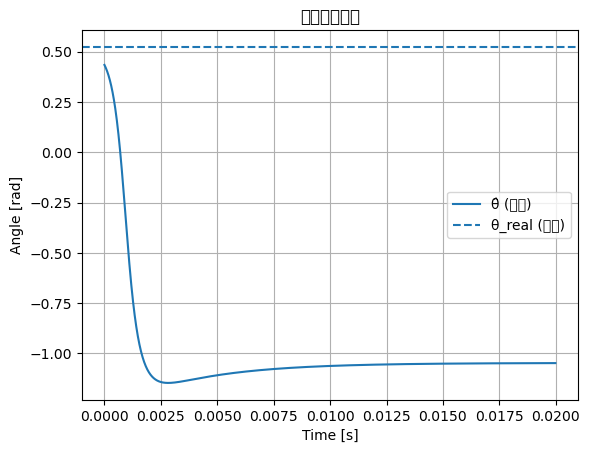

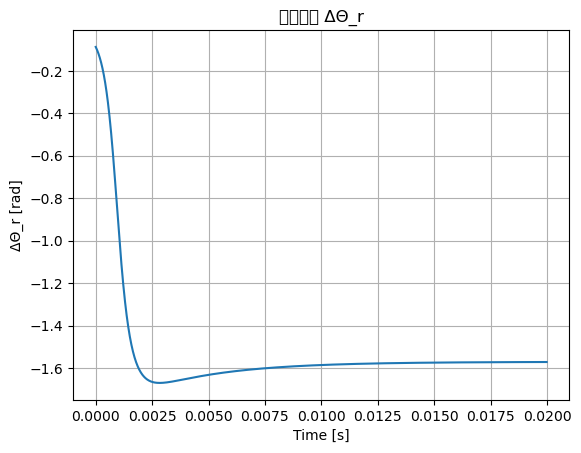

c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36600 (\N{CJK UNIFIED IDEOGRAPH-8EF8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sugusokothx\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  fig.canvas.print_figure(

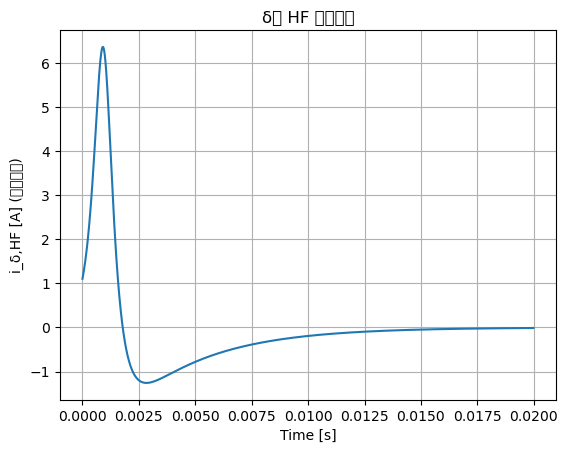

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────
# 0) 物理・制御パラメータ
# ─────────────────────────────────────────
# 注入電圧振幅 [V]
V1 = 20.0
# 注入周波数 [rad/s]
omega_h = 2 * np.pi * 1_000.0

# モータ高周波インダクタンス
Ld = 1.0e-3         # d軸
Lq = 1.5e-3         # q軸
DeltaL = Ld - Lq    # saliency（負値）

# 式(2.99)よりδ軸 HF 電流振幅は sin(2ΔΘ_r) に比例する
K_hf = V1 / (omega_h * DeltaL)      # 簡易比例係数

# ─────────────────────────────────────────
# 1) PLL ゲイン
# ─────────────────────────────────────────
Kp = 200.0          # 比例ゲイン
Ki = 5.0e4          # 積分ゲイン

# ─────────────────────────────────────────
# 2) シミュレーション設定
# ─────────────────────────────────────────
Ts   = 1.0e-5       # サンプリング周期 [s]
Tend = 0.02         # 解析時間 [s]
steps = int(Tend / Ts)

# 真のロータ電気角（シミュレーションでは静止）
theta_real = np.deg2rad(30.0)   # 30° オフセット

# 推定初期値
theta_hat = np.deg2rad(25.0)   # 初期誤差 50°

int_err = 0.0                   # 積分器状態

# ログ
t_log        = np.empty(steps)
theta_hat_log = np.empty(steps)
err_log      = np.empty(steps)
i_delta_log  = np.empty(steps)

# ─────────────────────────────────────────
# 3) メインループ
# ─────────────────────────────────────────
for k in range(steps):
    t = k * Ts
    # 位相誤差 ΔΘ_r = θ̂ - θ_real
    delta_theta = theta_hat - theta_real

    # δ軸 HF 電流振幅（式2.99の近似モデル）
    i_delta = K_hf * np.sin(2.0 * delta_theta)

    # PLL 誤差信号（符号反転で 0 へ収束）
    err = -i_delta

    # PI 制御器
    int_err += err * Ts
    omega_est = Kp * err + Ki * int_err

    # 推定角更新
    theta_hat += omega_est * Ts
    # wrap to [-π, π]
    theta_hat = (theta_hat + np.pi) % (2 * np.pi) - np.pi

    # ログ保存
    t_log[k]         = t
    theta_hat_log[k] = theta_hat
    err_log[k]       = delta_theta
    i_delta_log[k]   = i_delta

# ─────────────────────────────────────────
# 4) 可視化
# ─────────────────────────────────────────
plt.figure()
plt.plot(t_log, theta_hat_log, label='θ̂ (推定)')
plt.axhline(theta_real, linestyle='--', label='θ_real (真値)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('推定角の収束')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t_log, err_log)
plt.xlabel('Time [s]')
plt.ylabel('ΔΘ_r [rad]')
plt.title('位相誤差 ΔΘ_r')
plt.grid(True)

plt.figure()
plt.plot(t_log, i_delta_log)
plt.xlabel('Time [s]')
plt.ylabel('i_δ,HF [A] (モデル値)')
plt.title('δ軸 HF 電流振幅')
plt.grid(True)

plt.show()
